In [1]:
import os
import cv2
import pandas as pd
import torch
import json
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
from shutil import copyfile
from modules import config
# from model_pipeline import run_inference
import supervision as sv
from transformers import DetrImageProcessor, DetrForObjectDetection
from ultralytics import YOLO
from transformers import DetrForObjectDetection, DetrImageProcessor

/Users/akashmurali/anaconda3/envs/prcv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
#########################################
# Setup directories                     #
#########################################
test_folder_classification = "test_images/classification_images" # consists of all classification images for demo run
test_folder_localization = "test_images/localization_images" # consists of all object detection images for demo run
output_dir = "output"
model_dirs = {
    "resnet": {"fractured": os.path.join(output_dir, "resnet/fractured"), 
               "non_fractured": os.path.join(output_dir, "resnet/non_fractured")},
    "vgg": {"fractured": os.path.join(output_dir, "vgg/fractured"), 
            "non_fractured": os.path.join(output_dir, "vgg/non_fractured")},
    "yolo": os.path.join(output_dir, "yolo/bboxes"),
    "detr": os.path.join(output_dir, "detr/bboxes"),
    "rcnn": os.path.join(output_dir, "rcnn/bboxes")
}

In [15]:
# Create all directories
for model_name, dirs in model_dirs.items():
    if isinstance(dirs, dict):  # Classification models
        for sub_dir in dirs.values():
            os.makedirs(sub_dir, exist_ok=True)
    else:  # Object detection models
        os.makedirs(dirs, exist_ok=True)

In [16]:
###########################################
# setup device to cpu or gpu if available #
###########################################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
##########################################
# Load Resnet Model                      #
##########################################

print("Loading ResNet model...")
resnet_model_path = config.resnet_path
resnet_model = models.resnet18(pretrained=False)
num_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_features, 2)  # (fractured/non-fractured)
resnet_model.load_state_dict(torch.load(resnet_model_path, map_location=device))
resnet_model = resnet_model.to(device)
resnet_model.eval()

Loading ResNet model...


/Users/akashmurali/anaconda3/envs/prcv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/akashmurali/anaconda3/envs/prcv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
#############################################
# Load VGG Model                            #
#############################################

print("Loading VGG model...")
vgg_model_path = config.vgg19_path  # Replace with your model path
vgg_model = models.vgg19(pretrained=False)
vgg_model.classifier[6] = nn.Linear(vgg_model.classifier[6].in_features, 2)
vgg_model.load_state_dict(torch.load(vgg_model_path, map_location=device))
vgg_model = vgg_model.to(device)
vgg_model.eval()


Loading VGG model...


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [19]:
############################################
# Load YOLO model                          #
############################################
print("Loading YOLO model...")
yolo_model = YOLO(config.yolo_path)
print("Loaded YOLO Model")


Loading YOLO model...
Loaded YOLO Model


In [8]:
# Applying image transformation
classification_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [20]:

# inference function for resnet and vgg
def classify_image(img_path, model):
    img = Image.open(img_path).convert("RGB")
    img_tensor = classification_transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(img_tensor)
        _, preds = torch.max(outputs, 1)
    return preds.item()

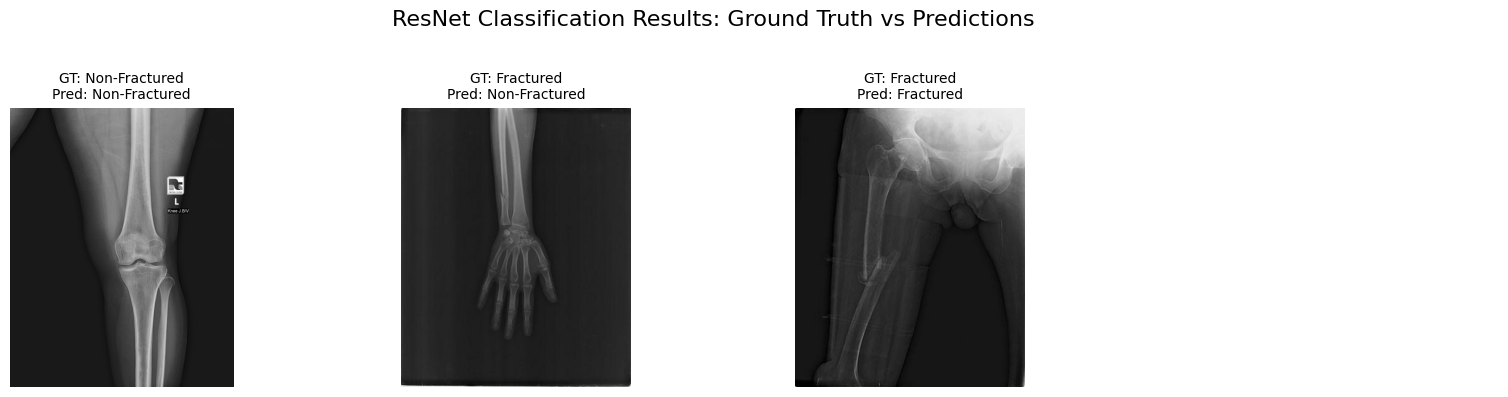

Classification results saved under 'output/resnet/fractured' and 'output/resnet/non_fractured'.


In [10]:
# Load ground truth file
ground_truth_file = "test_images/classification_ground_truth_file.csv"
ground_truth_df = pd.read_csv(ground_truth_file)

ground_truth_df['image_path'] = ground_truth_df['image_path'].apply(lambda x: os.path.normpath(x))

####################################################
# Run inference for ResNet                         #
####################################################
images = []
titles = []

for image_file in Path(test_folder_classification).glob("*.jpg"):
    relative_path = os.path.join('test_images/classification_images', image_file.name)
    relative_path = os.path.normpath(relative_path)
    
    ground_truth_row = ground_truth_df[ground_truth_df['image_path'] == relative_path]
    if ground_truth_row.empty:
        print(f"Warning: Ground truth not found for {relative_path}. Skipping.")
        continue
    ground_truth_label = "Fractured" if ground_truth_row['label'].values[0] == 1 else "Non-Fractured"
    
    resnet_label = classify_image(str(image_file), resnet_model)
    predicted_label = "Fractured" if resnet_label == 1 else "Non-Fractured"
    
    img = Image.open(image_file)
    images.append(img)
    titles.append(f"GT: {ground_truth_label}\nPred: {predicted_label}")
    
    # Save images in corresponding directories
    if resnet_label == 1:  # Predicted as Fractured
        target_path = os.path.join(model_dirs["resnet"]["fractured"], image_file.name)
        copyfile(image_file, target_path)
    else:  # Predicted as Non-Fractured
        target_path = os.path.join(model_dirs["resnet"]["non_fractured"], image_file.name)
        copyfile(image_file, target_path)

####################################################
# Visualization: Ground Truth vs Predictions       #
####################################################
num_images = len(images)
cols = 4
rows = (num_images // cols) + (num_images % cols > 0)

fig, axs = plt.subplots(rows, cols, figsize=(16, 4 * rows))
fig.suptitle("ResNet Classification Results: Ground Truth vs Predictions", fontsize=16)

for i, ax in enumerate(axs.flatten()):
    if i < num_images:
        ax.imshow(images[i])
        ax.set_title(titles[i], fontsize=10)
        ax.axis("off")
    else:
        ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print("Classification results saved under 'output/resnet/fractured' and 'output/resnet/non_fractured'.")

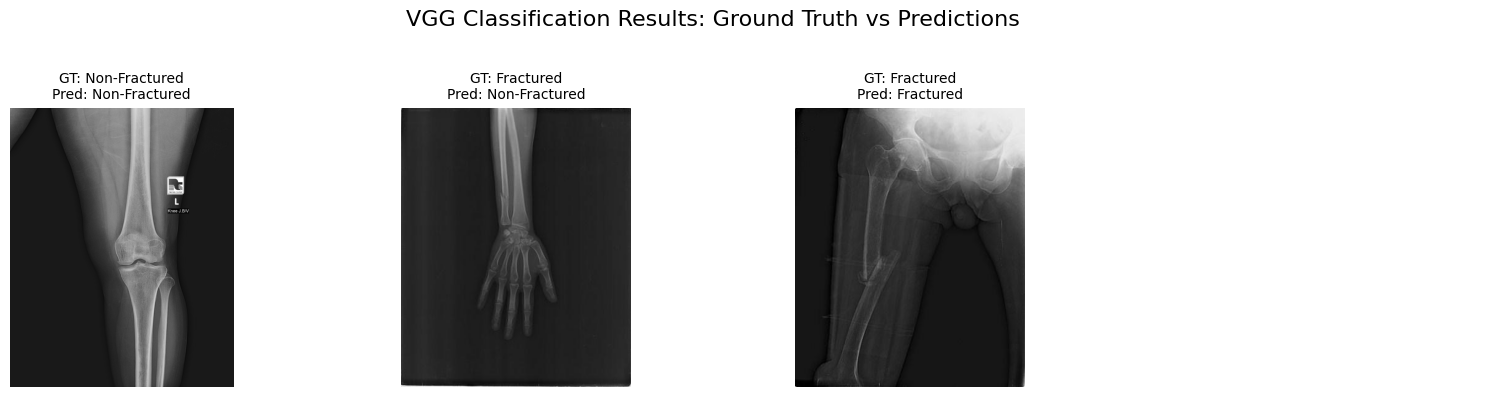

Classification results saved under 'output/vgg/fractured' and 'output/vgg/non_fractured'.


In [11]:
####################################################
# Run inference for VGG                            #
####################################################
images = []
titles = []

for image_file in Path(test_folder_classification).glob("*.jpg"):
    relative_path = os.path.join('test_images/classification_images', image_file.name)
    relative_path = os.path.normpath(relative_path)
    
    ground_truth_row = ground_truth_df[ground_truth_df['image_path'] == relative_path]
    if ground_truth_row.empty:
        print(f"Warning: Ground truth not found for {relative_path}. Skipping.")
        continue
    ground_truth_label = "Fractured" if ground_truth_row['label'].values[0] == 1 else "Non-Fractured"
    
    resnet_label = classify_image(str(image_file), vgg_model)
    predicted_label = "Fractured" if resnet_label == 1 else "Non-Fractured"
    
    img = Image.open(image_file)
    images.append(img)
    titles.append(f"GT: {ground_truth_label}\nPred: {predicted_label}")
    
    # Save images in corresponding directories
    if resnet_label == 1:  # Predicted as Fractured
        target_path = os.path.join(model_dirs["vgg"]["fractured"], image_file.name)
        copyfile(image_file, target_path)
    else:  # Predicted as Non-Fractured
        target_path = os.path.join(model_dirs["vgg"]["non_fractured"], image_file.name)
        copyfile(image_file, target_path)

####################################################
# Visualization: Ground Truth vs Predictions       #
####################################################
num_images = len(images)
cols = 4
rows = (num_images // cols) + (num_images % cols > 0)

fig, axs = plt.subplots(rows, cols, figsize=(16, 4 * rows))
fig.suptitle("VGG Classification Results: Ground Truth vs Predictions", fontsize=16)

for i, ax in enumerate(axs.flatten()):
    if i < num_images:
        ax.imshow(images[i])
        ax.set_title(titles[i], fontsize=10)
        ax.axis("off")
    else:
        ax.axis("off") 

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print("Classification results saved under 'output/vgg/fractured' and 'output/vgg/non_fractured'.")

Running inference on test images...

image 1/1 /Users/akashmurali/Documents/Computer Vision and Pattern Recognition/project/demo_script/test_images/localization_images/149_jpg.rf.dd92a5d9270c84b6029734793747547d.jpg: 640x640 2 fractureds, 169.4ms
Speed: 1.6ms preprocess, 169.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/akashmurali/Documents/Computer Vision and Pattern Recognition/project/demo_script/test_images/localization_images/IMG0002539_jpg.rf.b412f23abf5169f14f79c812b038f253.jpg: 640x640 1 fractured, 155.6ms
Speed: 1.5ms preprocess, 155.6ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


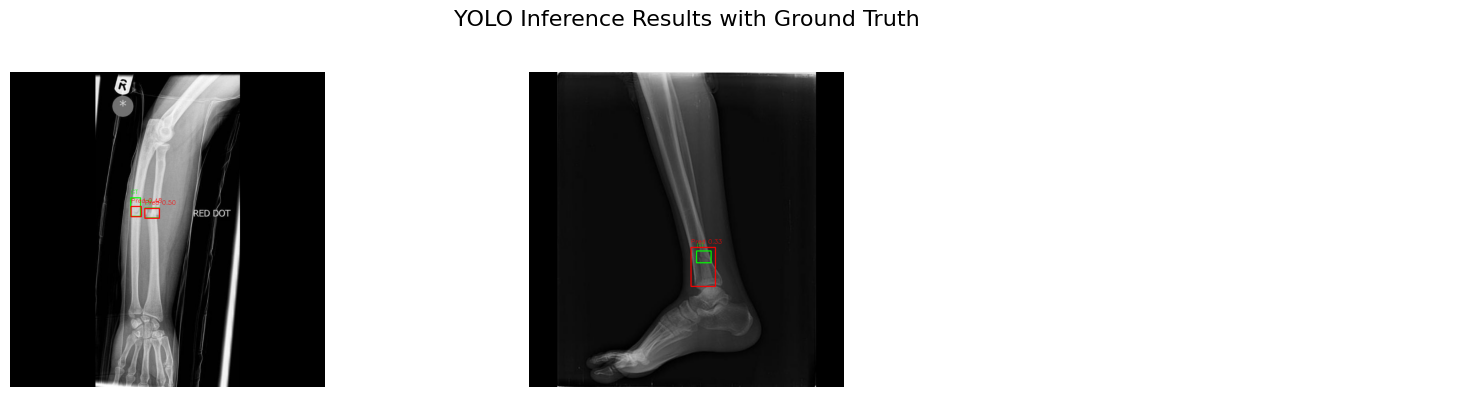

Inference complete. Annotated images saved in 'output/yolo/bboxes'


In [21]:
#########################################
# Run inference for Yolov8              #
#########################################

def draw_bounding_boxes(image, boxes, labels, color=(0, 0, 255)):
    """
    Draw bounding boxes on an image.

    Args:
        image (ndarray): The image to draw on.
        boxes (list of lists): Each box is [x_min, y_min, x_max, y_max] in pixel coordinates.
        labels (list): List of labels (e.g., confidence scores, class names).
        color (tuple): The color of the bounding box (BGR).
    """
    for box, label in zip(boxes, labels):
        x_min, y_min, x_max, y_max = map(int, box)
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 2)
        cv2.putText(image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

# Load ground truth COCO JSON
ground_truth_file = "test_images/coco_annotation/_annotations.coco.json"
with open(ground_truth_file, "r") as f:
    coco_data = json.load(f)

# Map image IDs to file names and annotations
image_id_to_filename = {img['id']: img['file_name'] for img in coco_data['images']}
image_id_to_annotations = {}
for ann in coco_data['annotations']:
    img_id = ann['image_id']
    if img_id not in image_id_to_annotations:
        image_id_to_annotations[img_id] = []
    image_id_to_annotations[img_id].append(ann)

# YOLO inference
annotated_images = []

print("Running inference on test images...")
image_files = list(Path(test_folder_localization).glob("*.jpg"))

for image_file in image_files:
    img = cv2.imread(str(image_file))
    if img is None:
        print(f"Warning: Could not read {image_file}. Skipping.")
        continue

    image_name = os.path.basename(image_file)
    image_id = None
    for id_, file_name in image_id_to_filename.items():
        if file_name == image_name:
            image_id = id_
            break
    
    if image_id is None:
        print(f"Warning: No ground truth found for {image_name}. Skipping.")
        continue

    # Extract ground truth bounding boxes and labels
    ground_truth_boxes = []
    ground_truth_labels = []
    for ann in image_id_to_annotations.get(image_id, []):
        bbox = ann['bbox']
        x_min, y_min, width, height = bbox
        ground_truth_boxes.append([x_min, y_min, x_min + width, y_min + height])
        ground_truth_labels.append("GT")

    # YOLO inference
    results = yolo_model.predict(source=str(image_file), save=False, conf=0.3)
    preds = results[0]
    
    # Extract predicted bounding boxes, scores, and class IDs
    pred_boxes = preds.boxes.xyxy.cpu().numpy()
    pred_scores = preds.boxes.conf.cpu().numpy()
    pred_class_ids = preds.boxes.cls.cpu().numpy()
    pred_labels = [f"Pred {score:.2f}" for score in pred_scores]
    
    # Draw ground truth and predicted bounding boxes
    draw_bounding_boxes(img, ground_truth_boxes, ground_truth_labels, color=(0, 255, 0))  # Green for GT
    draw_bounding_boxes(img, pred_boxes, pred_labels, color=(0, 0, 255))  # Red for Pred

    # Save annotated image
    output_file = os.path.join(model_dirs["yolo"], image_file.name)
    cv2.imwrite(output_file, img)

    # Store annotated image for visualization
    annotated_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Visualization
num_images = len(annotated_images)
cols = 3
rows = (num_images // cols) + (num_images % cols > 0)

fig, axs = plt.subplots(rows, cols, figsize=(16, 4 * rows))
fig.suptitle("YOLO Inference Results with Ground Truth", fontsize=16)

for i, ax in enumerate(axs.flatten()):
    if i < num_images:
        ax.imshow(annotated_images[i])
        ax.axis("off")
    else:
        ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print(f"Inference complete. Annotated images saved in '{model_dirs['yolo']}'")

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Model Loaded From HF
149_jpg.rf.dd92a5d9270c84b6029734793747547d.jpg


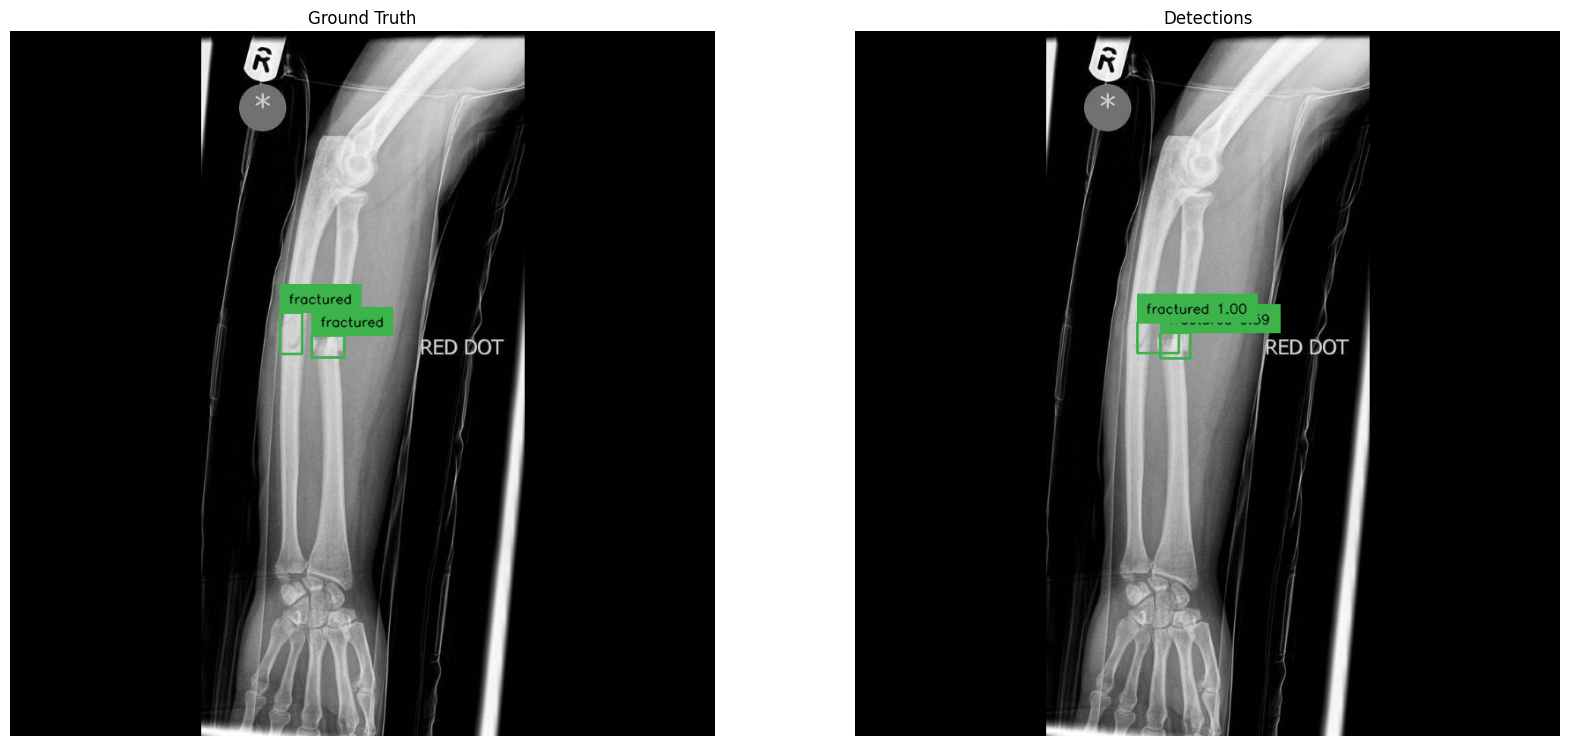

IMG0002539_jpg.rf.b412f23abf5169f14f79c812b038f253.jpg


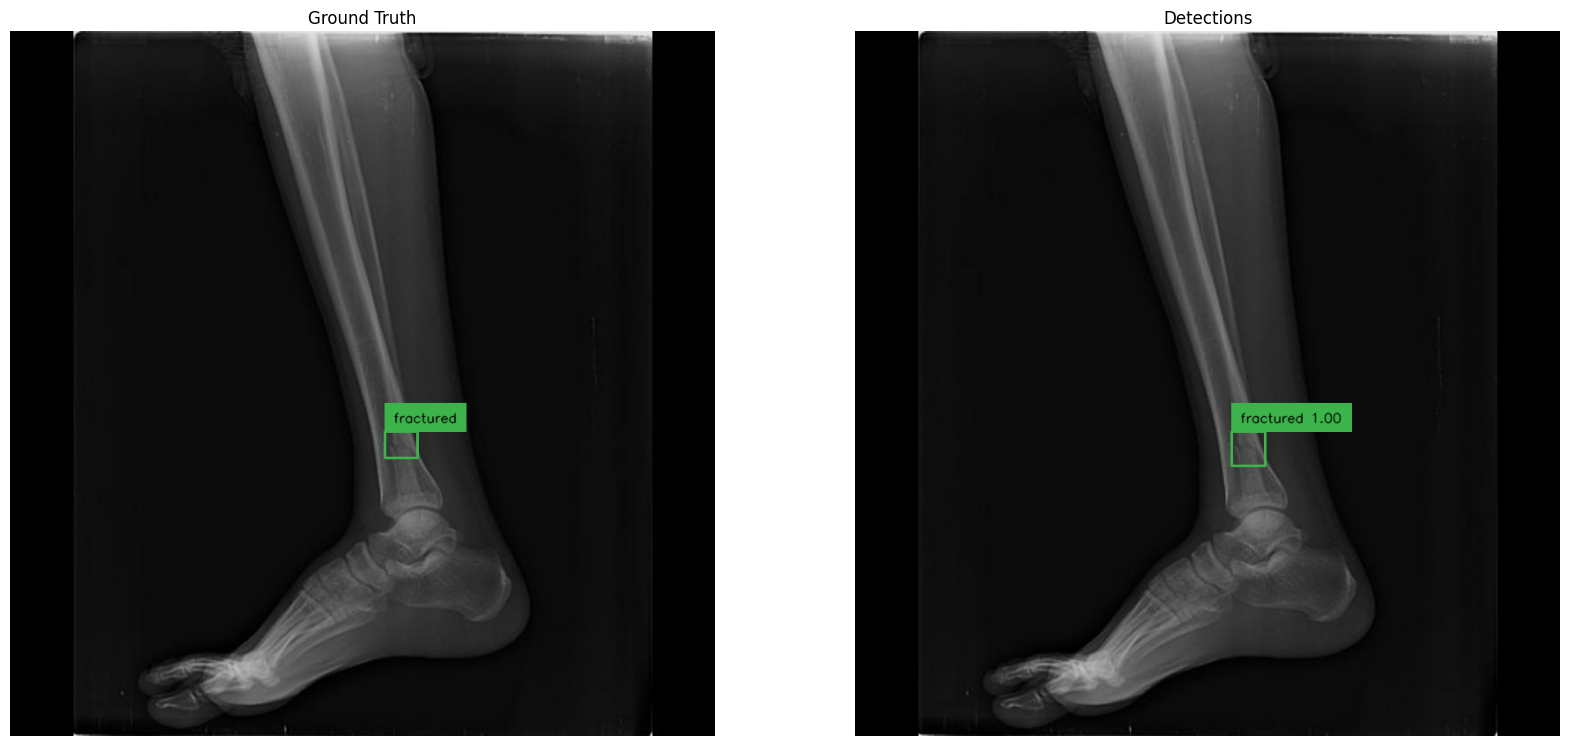

In [13]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import os
import supervision as sv
from transformers import DetrImageProcessor, DetrForObjectDetection

# Define the custom CocoDetection class
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, processor, ann_path, train=True):
        """
        Custom initialization for CocoDetection to include a processor.
        """
        super(CocoDetection, self).__init__(img_folder, ann_path)
        self.processor = processor

    def __getitem__(self, idx):
        """
        Custom getitem to preprocess image and target using the processor.
        """
        # Read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)

        # Preprocess image and target (convert target to DETR format, resizing + normalization)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()  # Remove batch dimension
        target = encoding["labels"][0]  # Remove batch dimension

        return pixel_values, target


# Load testing data and processor
testing_path = "test_images/localization_images"
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
val_dataset = CocoDetection(
    testing_path,
    processor=processor,
    ann_path="test_images/coco_annotation/_annotations.coco.json",
    train=False,
)

# Load the fine-tuned DETR model
model = DetrForObjectDetection.from_pretrained("D3STRON/bone-fracture-detr", id2label={1: "Fractured", 0: "Not"})
model.to("cpu")
model.eval()
print("Model Loaded From HF")

# Utils
categories = val_dataset.coco.cats
id2label = {k: v["name"] for k, v in categories.items()}
box_annotator = sv.BoxAnnotator()

path_processed = []
jpg_files = [f for f in os.listdir(testing_path) if f.lower().endswith(".jpg")]

for file in jpg_files:
    annotations = []

    # Find image ID from the file name
    image_id = None
    for temp_id in val_dataset.coco.getImgIds():
        path = val_dataset.coco.loadImgs(temp_id)[0]["file_name"]
        if path == file:
            image_id = temp_id
            print(file)
            image = val_dataset.coco.loadImgs(image_id)[0]
            image_path = os.path.join(val_dataset.root, image["file_name"])

    # Load image and annotations
    annotations = val_dataset.coco.imgToAnns[image_id]
    path_processed.append(image_path)
    image = cv2.imread(image_path)

    # Annotate ground truth
    detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
    labels = [f"{id2label[class_id]}" for _, _, class_id, _ in detections]
    frame_ground_truth = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)
    CONFIDENCE_THRESHOLD = 0.4
    DEVICE = "cpu"

    # Annotate detections
    with torch.no_grad():
        # Load image and predict
        inputs = processor(images=image, return_tensors="pt").to(DEVICE)
        outputs = model(**inputs)

        # Post-process
        target_sizes = torch.tensor([image.shape[:2]]).to(DEVICE)
        results = processor.post_process_object_detection(
            outputs=outputs,
            threshold=CONFIDENCE_THRESHOLD,
            target_sizes=target_sizes,
        )[0]
        detections = sv.Detections.from_transformers(transformers_results=results)
        labels = [f"{id2label[1]} {confidence:.2f}" for _, confidence, class_id, _ in detections]
        frame_detections = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

    # Display ground truth and predictions
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    axs[0].imshow(cv2.cvtColor(frame_ground_truth, cv2.COLOR_BGR2RGB))
    axs[0].axis("off")
    axs[0].set_title("Ground Truth")

    axs[1].imshow(cv2.cvtColor(frame_detections, cv2.COLOR_BGR2RGB))
    axs[1].axis("off")
    axs[1].set_title("Detections")

    plt.show()


In [ ]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch

processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-384", num_labels=2, ignore_mismatched_sizes=True)
model = AutoModelForImageClassification.from_pretrained("D3STRON/bone_fracture_vit", num_labels=2, ignore_mismatched_sizes=True)


data_files = {"test": "./classification_ground_truth_file.csv"}  # update with the correct path
dataset = load_dataset("csv", data_files=data_files)

def preprocess_data(examples):
    images = []
    for image_path in examples["image_path"]:
        image = Image.open(image_path).convert("RGB")
        augmented_image = image
        images.append(augmented_image)
    
    # Convert the list of images to tensors
    inputs = processor(images=images, return_tensors="pt")
    inputs["labels"] = examples["label"]
    return inputs

# Apply the preprocessing function
# prepared_dataset = dataset["train"].map(preprocess_data, batched=True, batch_size=16) 
test_dataset = dataset["test"].map(preprocess_data, batched=True, batch_size=16)


# Function to run inference and create grid visualization
def visualize_predictions(test_dataset, model, processor, num_samples=16):
    """
    Run inference on a subset of the validation set and display predictions with real labels.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()
    
    # Select a subset of samples
    samples = test_dataset.shuffle(seed=42).select(range(num_samples))
    
    # Prepare the figure
    fig, axes = plt.subplots(len(samples), 1, figsize=(10, 3*len(samples)))
    
    # If only one sample, convert axes to list for consistent indexing
    if len(samples) == 1:
        axes = [axes]
    
    # Label mapping
    label_map = {0: "No Fracture", 1: "Fracture"}
    
    # Iterate through selected samples
    for i in range(len(samples)):
        # Load image path and true label from the sample
        image_path = samples[i]["image_path"]
        true_label = samples[i]["label"]
        
        # Load and preprocess the image
        image = Image.open(image_path).convert("RGB")
        
        # Prepare input for the model
        inputs = processor(images=image, return_tensors="pt").to(device)
        
        # Run inference
        with torch.no_grad():
            outputs = model(**inputs)
            probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
            predicted_label = torch.argmax(probabilities, dim=-1).item()
        
        # Determine prediction correctness
        is_correct = true_label == predicted_label
        
        # Plot the image
        axes[i].imshow(image)
        axes[i].axis('off')
        
        # Add text with ground truth and prediction
        title_text = (
            f"Ground Truth: {label_map[true_label]} | "
            f"Predicted: {label_map[predicted_label]}"
        )
        
        # Color the title based on prediction correctness
        color = 'green' if is_correct else 'red'
        
        axes[i].set_title(title_text, color=color, fontsize=12)
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Run the visualization function
visualize_predictions(test_dataset=test_dataset, model=model, processor=processor, num_samples=3)